In [17]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
from collections import OrderedDict
from copy import deepcopy
import seaborn as sns
from statannot import add_stat_annotation
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

# Read data

In [14]:
df = pd.read_csv('processed_count_table_0915.csv', index_col=0)
df = df[df.Gene.notnull()]
df = df.set_index('Strain', drop=True)

rmlGenes = ['rmlA','rmlB','rmlC','rmlD']
qmsGenes = ['lasA','lasB','lasI','lasR','pqsA','pqsB','pqsC','pqsD','pqsE','pqsH']
rhmnoGenes = ['rhlA', 'rhlB', 'rhlC', 'rhlI', 'rhlR']
otherGenes = ['zwf','PA14_70560','katA','katB','ahpC','ahpF','grx','gor','trxA','trxB1','trxB2']
allGenes = rmlGenes + qmsGenes + rhmnoGenes + otherGenes
print('%d genes in total.'%(len(allGenes)))

for g in allGenes:
    if g not in list(df.Gene):
        print('%s not found.'%(g))

df_strain_by_rhamnolipid_production = pd.read_excel('../data/rhamnolipids/rhamnMat.xlsx',index_col=0)
df_strain_by_rhamnolipid_production = df_strain_by_rhamnolipid_production.rename(index={'PA14':'UCBPP-PA14'})
df = pd.merge(df, df_strain_by_rhamnolipid_production, left_index=True, right_index=True, how='left')
df = df.sort_values('rhamn3cats', ascending=True)
df.rhamn3cats = df.rhamn3cats.astype(str)
df

30 genes in total.


,Count,Replicate,Gene,LocusTag,rhamn3cats,rhamn2cats
M1608,2563.248752,1,ipk,PA14_61750,0,0
M1608,1776.540460,3,mtnA,PA14_23250,0,0
M1608,2108.978554,2,mtnA,PA14_23250,0,0
M1608,2408.457970,1,mtnA,PA14_23250,0,0
M1608,2262.641097,3,PA14_23240,PA14_23240,0,0
...,...,...,...,...,...,...
UCBPP-PA14,26.460771,3,PA14_34170,PA14_34170,2,1
UCBPP-PA14,28.084660,2,PA14_34170,PA14_34170,2,1
UCBPP-PA14,30.876936,1,PA14_34170,PA14_34170,2,1
UCBPP-PA14,72.812081,2,PA14_34200,PA14_34200,2,1


# Box and strip plot

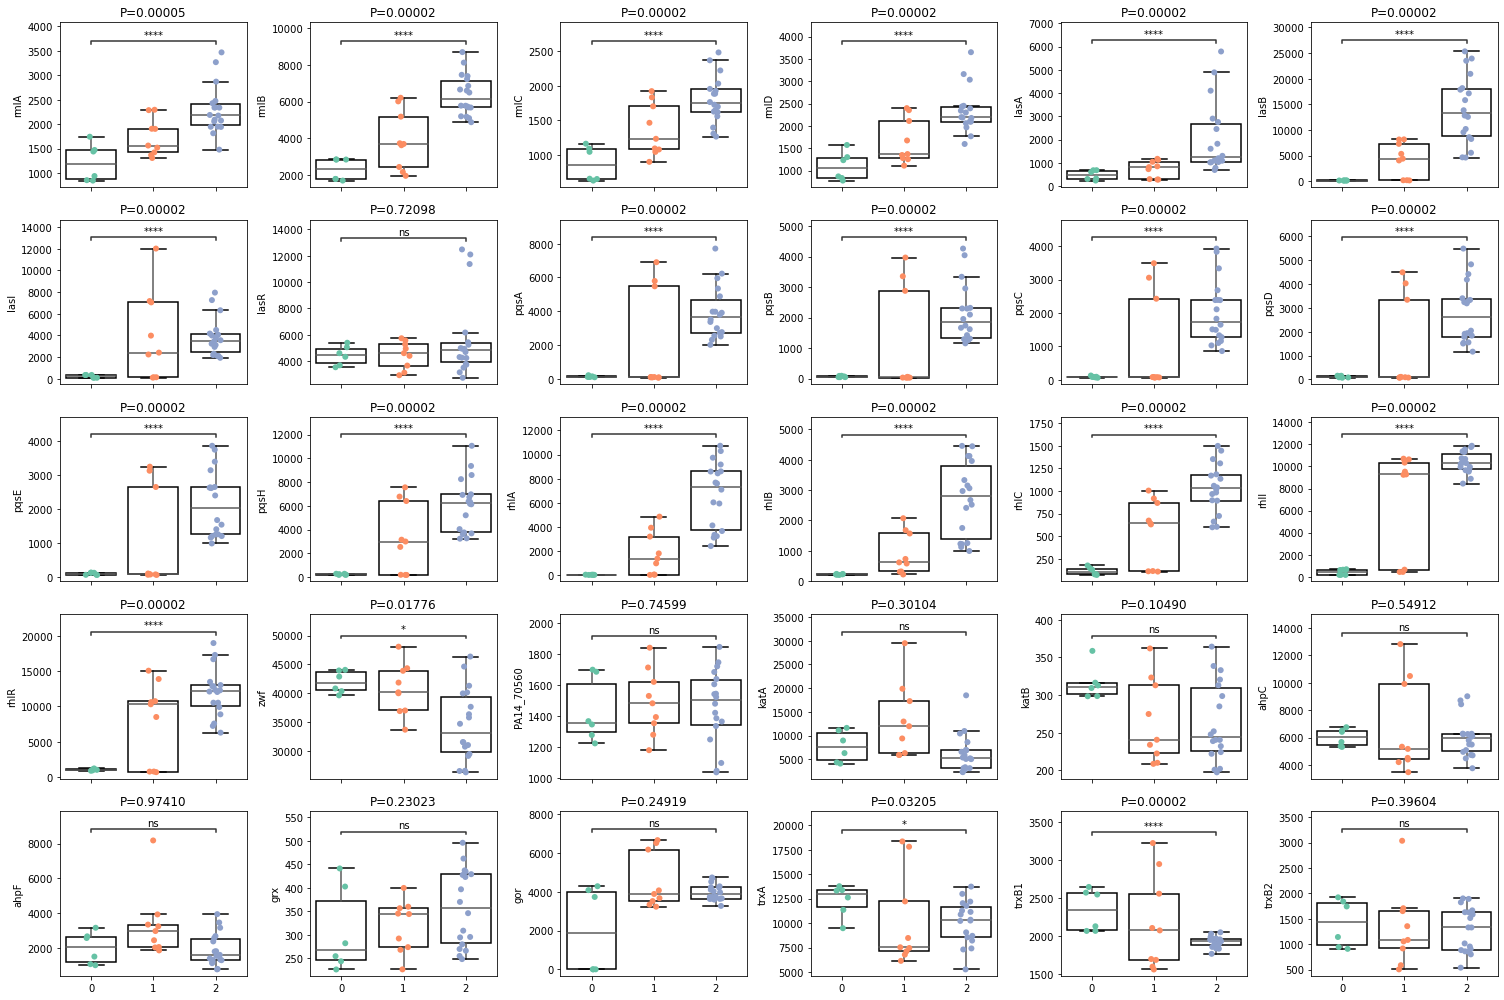

In [20]:
fig, ax = plt.subplots(nrows=5, ncols=6, figsize=(3*n,2*n), sharex=True)

PROPS = {
    'boxprops':{'facecolor':'none', 'edgecolor':'black'},
    'capprops':{'color':'black'}
}
Pvalues = []
for k,g in enumerate(allGenes):
    row = int(k/6)
    col = k%6
    
    # plot
    df2 = df[df.Gene==g]
    _ = sns.boxplot(x='rhamn3cats', y='Count', ax=ax[row,col], data=df2, palette="Set2", **PROPS, showfliers=False, order=['0','1','2'])
    _ = sns.stripplot(x='rhamn3cats', y='Count', ax=ax[row,col], data=df2, palette="Set2", s=6, order=['0','1','2'])
    _ = ax[row,col].set_xlabel(None)
    _ = ax[row,col].set_ylabel(g)
    
    add_stat_annotation(ax[row,col], data=df2, x='rhamn3cats', y='Count', order=['0','1','2'],
                        box_pairs=[("0", "2")],
                        test='Mann-Whitney', text_format='star',loc='inside', verbose=0)
    Pvalues.append(mannwhitneyu(df2.loc[df2.rhamn3cats=='0','Count'],df2.loc[df2.rhamn3cats=='2','Count'])[1])

Padjs = multipletests(Pvalues, method='fdr_bh')[1]
for k,g in enumerate(allGenes):
    row = int(k/6)
    col = k%6
    ax[row,col].set_title('P=%2.5f'%(Padjs[k]))
    
plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
plt.savefig('boxplot_individual_genes.svg', dpi=600)